# La baseline 

In [1]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import matplotlib.gridspec as gridspec
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library
from tqdm import tqdm #progress bar

import time
import os
import pickle

import torch

In [2]:
torch.cuda.is_available()
device = "cuda:0" if torch.cuda.is_available() else "cpu" #0 indicates the GPU you gonna use 
print(f"Using {device} device")

Using cuda:0 device


In [3]:
from torchvision import datasets
from torchvision import transforms


transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
# set transformation

traindata = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testdata = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



AxesImage(54,36;334.8x217.44)
60000
10000


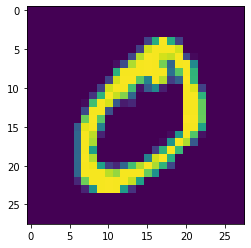

In [4]:
print(plt.imshow(traindata[1][0].view(28,28)))
print(len(traindata))
print(len(testdata))

In [182]:
from sklearn.model_selection import train_test_split
random_state = 2023 #for reproductible results
train_indices, labeled_indices = train_test_split(list(range(len(traindata.targets))), test_size=100, stratify=traindata.targets,random_state=random_state)

In [183]:
trainset = torch.utils.data.Subset(traindata, train_indices)
labeledset = torch.utils.data.Subset(traindata, labeled_indices)

In [184]:
batch_size_labeled = 50
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
labeledloader = torch.utils.data.DataLoader(labeledset, batch_size=batch_size_labeled,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [185]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): #must correspond to the previous model set, comme un héritage
    def __init__(self):
      super(Net, self).__init__()  #pour surpasser l'initialisation de la classe nn.Module
      # to fill
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same") 
      # the three arguments in_channels,out_channels,kernel_size must be filled, the others are optionnal and have default values
      # out_channels correspond to the number of filters
      # if heigth=width in the kernel size, just set one value
      # stride is set to 0 by default
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same") 
      self.pool = nn.MaxPool2d(kernel_size= 2) # pooling layer
      self.dp1 = nn.Dropout(p=0.25) # probability of an element to be set to 0.
      #self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=512) # fully connected layer
      self.fc1 = nn.Linear(in_features= 32 * 14 * 14, out_features=512)
      self.dp2 = nn.Dropout(p=0.5) # probability of an element to be set to 0.
      self.fc2 = nn.Linear(in_features= 512, out_features=10) # fully connected layer


    def forward(self, x):
      # to fill with sequential pass through the model
      # i.e the input data 'x' must pass sequentially through the layers defined in '__init__'
      x = F.relu(self.conv1(x))
      x = self.pool(F.relu(self.conv2(x)))
      #x = self.dp1(x)
      x = torch.flatten(x,1) #flaten all dimensions except batch
      #x = self.dp2(F.relu(self.fc1(x)))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x 

In [186]:
model = Net().to(device) 
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [187]:
import torch.optim as optim

output_fn = torch.nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [188]:
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

In [189]:
from tqdm import tqdm


def train_func(train_loader, val_loader, model=None, epochs:int=None, optimizer=None, criterion=None):

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  for epoch in tqdm(range(epochs)):

    # Training
    model.train()
    running_loss = 0.0
    for idx,batch in enumerate(train_loader):

      # get the inputs; batch is a list of [inputs, labels]
      inputs,labels=batch
      inputs=inputs.to(device) #train on GPU
      labels=labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      out = model(x=inputs)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval()  
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction                       
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item())) 
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    with torch.no_grad():
      idx = 0
      for batch in train_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))   
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

    acc_train.append(get_accuracy(ground_truth,t_out))
    loss_train.append(np.mean(t_loss))

    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
      '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))
    

  return model, (loss_train, acc_train, loss_valid, acc_valid)

In [190]:
epochs = 20

args_train = {"train_loader" : labeledloader,
              "val_loader" : testloader,
              "model" : model,
              "epochs" : epochs,
              "optimizer" : optimizer,
              "criterion" : criterion}

net, (loss_train, acc_train, loss_valid, acc_valid) = train_func(**args_train)

  5%|▌         | 1/20 [00:02<00:40,  2.11s/it]

| Epoch: 1/20 | Train: Loss 5.8189 Accuracy : 0.1400 | Val: Loss 6.2400 Accuracy : 0.1178



 10%|█         | 2/20 [00:04<00:37,  2.07s/it]

| Epoch: 2/20 | Train: Loss 1.4906 Accuracy : 0.6800 | Val: Loss 1.7558 Accuracy : 0.4596



 15%|█▌        | 3/20 [00:06<00:34,  2.05s/it]

| Epoch: 3/20 | Train: Loss 0.5859 Accuracy : 0.8600 | Val: Loss 1.1314 Accuracy : 0.6478



 20%|██        | 4/20 [00:08<00:33,  2.08s/it]

| Epoch: 4/20 | Train: Loss 0.1525 Accuracy : 0.9600 | Val: Loss 0.9734 Accuracy : 0.7516



 25%|██▌       | 5/20 [00:10<00:30,  2.06s/it]

| Epoch: 5/20 | Train: Loss 0.0288 Accuracy : 0.9900 | Val: Loss 1.1312 Accuracy : 0.7648



 30%|███       | 6/20 [00:12<00:28,  2.05s/it]

| Epoch: 6/20 | Train: Loss 0.0644 Accuracy : 0.9900 | Val: Loss 1.7208 Accuracy : 0.7293



 35%|███▌      | 7/20 [00:14<00:26,  2.05s/it]

| Epoch: 7/20 | Train: Loss 0.0034 Accuracy : 1.0000 | Val: Loss 1.7424 Accuracy : 0.7746



 40%|████      | 8/20 [00:16<00:24,  2.03s/it]

| Epoch: 8/20 | Train: Loss 0.0068 Accuracy : 1.0000 | Val: Loss 2.1332 Accuracy : 0.7545



 45%|████▌     | 9/20 [00:18<00:22,  2.02s/it]

| Epoch: 9/20 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 2.3808 Accuracy : 0.7540



 50%|█████     | 10/20 [00:20<00:20,  2.02s/it]

| Epoch: 10/20 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 2.7121 Accuracy : 0.7475



 55%|█████▌    | 11/20 [00:22<00:18,  2.03s/it]

| Epoch: 11/20 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 2.9541 Accuracy : 0.7469



 60%|██████    | 12/20 [00:24<00:16,  2.01s/it]

| Epoch: 12/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.1651 Accuracy : 0.7480



 65%|██████▌   | 13/20 [00:26<00:14,  2.01s/it]

| Epoch: 13/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.3670 Accuracy : 0.7480



 70%|███████   | 14/20 [00:28<00:12,  2.02s/it]

| Epoch: 14/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.5571 Accuracy : 0.7456



 75%|███████▌  | 15/20 [00:30<00:10,  2.03s/it]

| Epoch: 15/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.7317 Accuracy : 0.7435



 80%|████████  | 16/20 [00:32<00:08,  2.05s/it]

| Epoch: 16/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.8851 Accuracy : 0.7411



 85%|████████▌ | 17/20 [00:35<00:06,  2.33s/it]

| Epoch: 17/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.0173 Accuracy : 0.7396



 90%|█████████ | 18/20 [00:38<00:04,  2.37s/it]

| Epoch: 18/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.1248 Accuracy : 0.7390



 95%|█████████▌| 19/20 [00:40<00:02,  2.27s/it]

| Epoch: 19/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.2071 Accuracy : 0.7388



100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

| Epoch: 20/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.2647 Accuracy : 0.7379



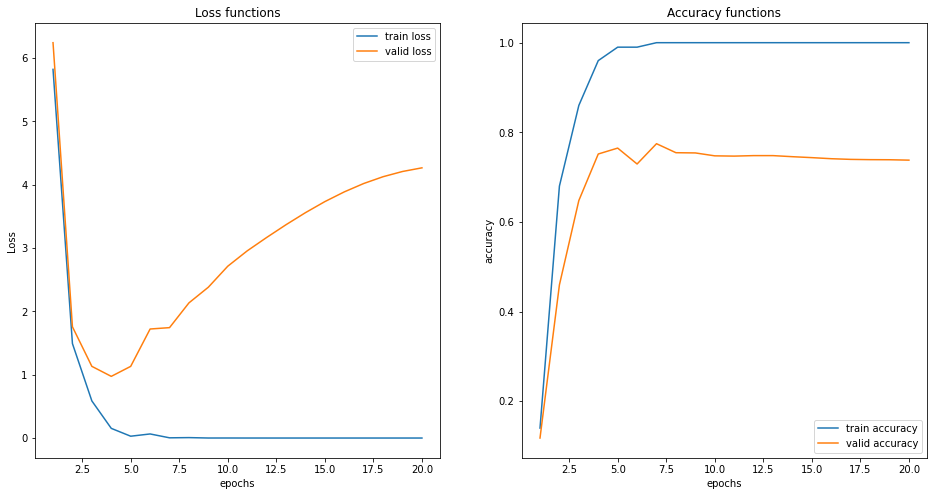

In [192]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(range(1,epochs + 1), loss_train, label="train loss" )
plt.plot(range(1, epochs +1), loss_valid, label="valid loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Loss functions")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,epochs + 1), acc_train, label="train accuracy" )
plt.plot(range(1, epochs +1), acc_valid, label="valid accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy functions")
plt.legend()
plt.show()

# Références 

https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e
https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf
